Dataset from:
https://doi.org/10.1007/s11263-019-01215-y

Pose Pipeline:
* For each frame in a video:
    * bounding box with YoloV8 for each person
        * for each bounding box perform pose detection with mediapipe and encode coordinates
Model Classification:
* run coordinates through our Deep Learning Model & output estimated Body Language Emotion & strength

In [3]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt

from ultralytics import YOLO
from ultralytics.yolo.v8.detect.predict import DetectionPredictor

import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

AttributeError: module 'cv2' has no attribute 'setNumThreads'

In [5]:
train = pd.read_csv('annotations/train.csv')
test = pd.read_csv('annotations/val.csv')


emotion = ["Peace","Affection", "Esteem","Anticipation","Engagement","Confidence", "Happiness"
"Pleasure" ,"Excitement", "Surprise","Sympathy","Doubt/Confusion", "Disconnection","Fatigue", "Embarrassment",
"Yearning", "Disapproval", "Aversion", "Annoyance", "Anger", "Sensitivity", "Sadness", "Disquietment","Fear", 
"Pain", "Suffering"]

#4 metadata + 26 emotion levels(0.0-1.0 percent) + valence(1-10) + arousal(1-10) + dominance(1-10) + gender(0-1) + age(0-2)
# + ethnicity(0-6) + confidence (0.0-1.0)

train.head() #video path, person id, framerange start, framerange end, 26 columns for emotion classification, gender, age, ethnicity, confidence of current sample ground truth

,video path,person id,framerange start,framerange end,peace,affection,esteem,anticipation,engagement,confidence,...,fear,pain,suffering,valence,arousal,dominance,gender,age,ethnicity,confidence of current sample ground truth
0,003/IzvOYVMltkI.mp4/0114.mp4,3,96,124,7.584470e-01,2.456076e-01,7.624894e-01,1.000000e+00,1.950000e-16,1.240000e-144,...,0.000000e+00,0.000000e+00,1.920000e-168,7.399637,5.347943,5.037566,0,2,5,0.989108
1,003/IzvOYVMltkI.mp4/0114.mp4,4,65,124,3.199790e-02,1.820000e-135,3.190000e-32,1.000000e+00,1.780000e-96,5.619127e-01,...,3.970000e-254,7.980000e-129,5.700000e-70,8.196524,8.125158,5.751267,1,2,6,0.995089
2,003/y7ncweROe9U.mp4/0130.mp4,0,20,72,3.460000e-11,1.680000e-11,1.590000e-73,6.120000e-143,3.441052e-02,1.190000e-187,...,2.630000e-90,3.660000e-45,1.889652e-01,3.418884,7.433074,7.020448,0,2,6,0.996510
3,003/y7ncweROe9U.mp4/0130.mp4,1,0,50,1.317727e-01,6.020000e-81,4.019926e-02,1.436238e-01,7.467580e-01,1.182821e-01,...,0.000000e+00,3.940000e-59,3.214524e-01,3.668987,4.300627,6.929638,0,2,6,0.995974
4,003/IKdBLciu_-A.mp4/0015.mp4,0,0,158,3.350000e-31,0.000000e+00,2.455900e-02,1.470000e-59,1.262255e-01,4.050000e-49,...,9.340000e-118,0.000000e+00,1.260000e-132,4.439887,4.951530,5.892768,0,2,6,0.997584


In [4]:
6891/9222 #videos with 1 person

0.747234873129473

<AxesSubplot:>

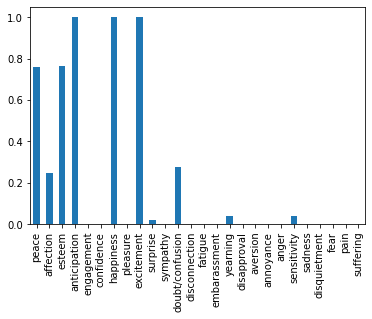

In [20]:
train.iloc[0, 4:30].plot.bar()

<AxesSubplot:>

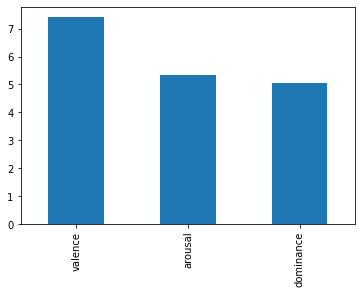

In [17]:
train.iloc[0, 30:-4].plot.bar() #scaled 1-10, scale this down to [0,1]

In [122]:
cap = cv2.VideoCapture(r'C:\Users\Alex Zavalny\Desktop\BOLD_public\videos\003\_7oWZq_s_Sk.mp4\0907.mp4')
ret, frame = cap.read()

persondetector = YOLO("yolov8s.pt")
res = persondetector.predict(frame, stream=False)


0: 480x640 2 persons, 1 cup, 222.4ms
Speed: 4.0ms preprocess, 222.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


tensor([[ 70.7264,  96.5205, 475.7040, 359.6005],
        [  6.8748,  16.2470, 185.8816, 359.2430],
        [106.6260, 288.7574, 174.2202, 359.8020]])
70 96 475 359
6 16 185 359
106 288 174 359


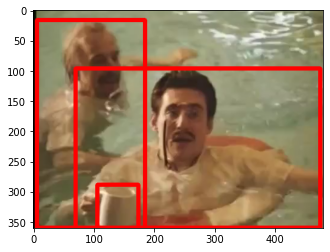

In [128]:
def plot_img(image,coords, category):
    x1=int(coords[0])
    y1=int(coords[1])
    x2=int(coords[2])
    y2=int(coords[3])
    print(x1,y1,x2,y2)
    cv2.putText(image, category, (x1,y1), 0, 1, (255, 0, 0), 15, cv2.LINE_AA)
    image = cv2.rectangle(image, (x1, y1), (x2, y2), (0,0,255), 5)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
bbox = []
for r in res:
    print(r.boxes.xyxy)
    bbox = r.boxes.xyxy
    
for i in range(bbox.shape[0]):
    plot_img(frame, bbox[i], "")

245 186
245 255
148 262
338 246
430 271
229 167
265 169
201 182
291 186


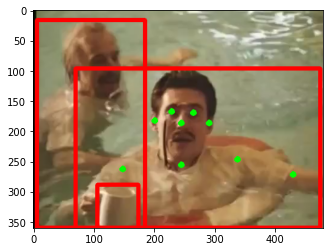

In [113]:
poses = np.load(r'C:\Users\Alex Zavalny\Desktop\BOLD_public\joints\003\_7oWZq_s_Sk.mp4\0907.npy')
n=1
for i in range(0, 54, 3):
    if poses[n, 2:][i+2] > 0:
        print(int(poses[n, 2:][i]), int(poses[n, 2:][i+1]))
        cv2.circle(frame, (int(poses[n, 2:][i]), int(poses[n, 2:][i+1])), 5, (0, 255, 0),thickness=-1, lineType=cv2.FILLED)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

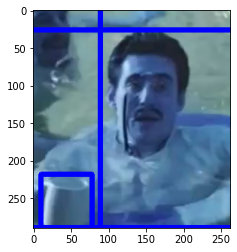

In [135]:
plt.imshow(frame[70:475, 96:359])

(<matplotlib.image.AxesImage at 0x2e758623700>,
        0         1         2         3         4         5         6     \
 0  0.508546  0.557652 -0.280083  0.999764  0.537496  0.500135 -0.231685   
 
        7         8         9     ...      1994  1995      1996      1997  \
 0  0.999517  0.551668  0.502463  ... -0.002478   0.0  0.567929  0.475738   
 
        1998  1999      2000      2001      2002  2003  
 0  0.007983   0.0  0.572672  0.469707  0.008102   0.0  
 
 [1 rows x 2004 columns])

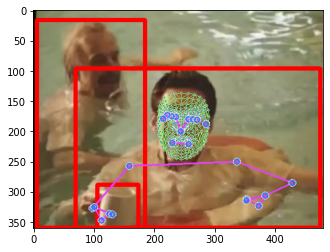

In [130]:
plt.imshow(cv2.cvtColor(drawClassInstance(frame)[0], cv2.COLOR_BGR2RGB)), drawClassInstance(frame)[1]

In [7]:
persondetector = YOLO("yolov8s.pt")

for path in list(train["video path"]):
    cap = cv2.VideoCapture(path)
    ret, frame = cap.read()
    
    START_FRAME
    
    cap.set(0, int(round(START_FRAME*fps)))
    
    while cap.isOpened():
        if ret == True:
            #bounding box + pose detection for each person
            res = persondetector.predict(frame, stream=False)
            #check if res is person only
            bbox = []
            for r in res:
                print(r.boxes.xyxy)
                bbox = r.boxes.xyxy
    
                for i in range(bbox.shape[0]):
                    #crop video with bbox[i]
        else:
            break

0       003/IzvOYVMltkI.mp4/0114.mp4
1       003/IzvOYVMltkI.mp4/0114.mp4
2       003/y7ncweROe9U.mp4/0130.mp4
3       003/y7ncweROe9U.mp4/0130.mp4
4       003/IKdBLciu_-A.mp4/0015.mp4
                    ...             
9217    003/053oq2xB3oU.mp4/0388.mp4
9218    003/xp67EC-Hvwk.mp4/0079.mp4
9219    003/xp67EC-Hvwk.mp4/0079.mp4
9220    003/IzvOYVMltkI.mp4/0114.mp4
9221    003/IzvOYVMltkI.mp4/0114.mp4
Name: video path, Length: 9222, dtype: object

In [123]:
#modified:
#https://github.com/nicknochnack/Body-Language-Decoder
def drawClassInstance(frame):
    # Initiate holistic model
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = holistic.process(image)

        # face_landmarks, pose_landmarks, left_hand_landmarks, right_hand_landmarks

        # Recolor image back to BGR for rendering
        image.flags.writeable = True   
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # 1. Draw face landmarks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
        mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
        mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
        )

        # 2. Right hand
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
        mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
        )

        # 3. Left Hand
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
        mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
        )

        # 4. Pose Detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
        mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
        mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )

        # Export coordinates
        try:
            # Extract Pose landmarks
            if results.pose_landmarks == None:
                return None
            pose = results.pose_landmarks.landmark
            pose_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in pose]).flatten())

            # Extract Face landmarks
            if results.face_landmarks == None:
                return None

            face = results.face_landmarks.landmark
            face_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in face]).flatten())

            # Concate rows
            row = pose_row+face_row

            # (x,y,z,visibility) for each 501 coordinates to make 2004
            X = pd.DataFrame([row])
            return (image, X)
        except:
            raise FileNotFoundError


* Frame by Frame detection:
    * For each frame run pose pipeline & predict on each pose
* Multi frame detection:
    * For x number of frames, run pose pipeline on each frame & concatenate or stack together coordinates
   

### Our model: 
$$f(\vec{X})\to \vec{y}, \\f([2004]) \to [26, 3]$$ 



In [ ]:
os.chdir("..")
os.getcwd()

In [ ]:
starts = list(train.iloc[:,2].to_numpy())
ends = list(train.iloc[:,3].to_numpy())

appeared = {} #only detect one person
clipnum = 0

coords = []
videos = list(train.iloc[:, 0].to_numpy())[:20]
for videopath in videos:
    #we haven't see this clip before:
    try:
        appeared[videopath]
        continue
    except KeyError:
        framenum = 0
        appeared[videopath] = 1
        START_FRAME = starts[clipnum]
        END_FRAME = ends[clipnum]
        
        current = videopath.split('/')
        root = os.getcwd()
        absolutepath = os.path.join(os.getcwd()[:-3], current[0], current[1], current[2])
        
        print(clipnum/len(videos), absolutepath)
        cap = cv2.VideoCapture(absolutepath)
        fps = cap.get(cv2.CAP_PROP_FPS)
        cap.set(0, int(round(START_FRAME*fps)))
        
        while cap.isOpened() and framenum <= END_FRAME:
            ret, frame = cap.read()
            if ret == True:
                det = drawClassInstance(frame)
                if det != None:
                    coords.append((videopath, list(det[1].to_numpy()[0])))
            else:
                break
            framenum+=1
        clipnum +=1

Training data: [2004] for each frame, hundreds of frames per individual sample of emotion


In [ ]:
coords

In [ ]:
import json

train = {"train":coords}

json.dump(train, open('train.json', 'w'))

In [ ]:
coords[0]

In [ ]:
#Prevent overfitting

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.97) and (logs.get('accuracy')>0.99) and (logs.get('val_loss')<0.2):
            print("\nReached 97% accuracy so cancelling training")
            self.model.stop_training = True

callbacks = myCallback()

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.models.Sequential([ 
    keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=X_train.shape[1:3]),
    keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu"),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid')])

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train_enc, epochs=50, validation_data=(X_test, y_test_enc), callbacks=[callbacks])

In [ ]:
import json

json.dump(history.history, open('/content/model_history.json', 'w'))

In [ ]:
model.save("BodyLanguageClassifier.h5")